# COGS 108 - EDA Checkpoint

# Names
- Nathan Ahmann
- Alex Guan
- Alan Miyazaki
- Renaldy Herlim

<a id='research_question'></a>
# Research Question

Does crime happen more or less frequently around police stations and can that knowledge be used to more effectively distribute police station locations?

# Setup

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime

import geopandas as gpd

# Data Cleaning

Since the two crime datasets were from the same organization (LAPD), the two sets were really easy to combine. The only change that needed to be done was that the dataset from 2010-2019 had a space in column name for Area while the dataset for 2020-present did not. Aside from this, all other columns were the same and the datasets were easily combined. 

In [23]:
# Reading datasets from two different time periods

# https://data.lacity.org/Public-Safety/Crime-Data-from-2010-to-2019/63jg-8b9z
past_df = pd.read_csv("Crime_Data_from_2010_to_2019.csv", dtype = {"TIME OCC": str})
# https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8
present_df = pd.read_csv("Crime_Data_from_2020_to_Present.csv", dtype = {"TIME OCC": str})

LAPD_df = pd.read_csv("LAPD_Police_Stations.csv")

# past dataset has column name typo
past_df = past_df.rename(columns={"AREA ": "AREA"})

# Both datasets use the same columns 
df = pd.concat([past_df, present_df])

The crime dataset had quite a few columns that were unnecessary to us. Mainly these were columns containing codes that law enforcement used internally. However, these columns usually had a description column in the dataset so the code column was unnecessary for us. The only exception were Mocodes and Part 1-2 which are internally used codes but did not contain an associated description column. However after looking into what these codes meant, it was decided that they did not provide any use to us and were removed. In addition to this, we also removed Date Rptd, date crime was reported, since we only care about when the crime occured and not when it was reported. We also replaced the codes in Vict Descent with their actual descriptions that was provided in the site the dataset came from. 

In [ ]:
# Dropping code columns since these are internal use and we don't get much 
# value from them given we have their description in a seperate column
df = df.drop(columns=[
    "Crm Cd", "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", 
    "Crm Cd 4", "Premis Cd", "Weapon Used Cd", 
    "Mocodes", "Part 1-2", "Status", "Date Rptd"
    ])

# Changed code to be readable description
df["Vict Descent"] = df["Vict Descent"].replace({
                            "A": "Other Asian", 
                            "B": "Black", 
                            "C": "Chinese", 
                            "D": "Cambodian", 
                            "F": "Filipino", 
                            "G": "Guamanian", 
                            "H": "Hispanic/Latin/Mexican", 
                            "I": "American Indian/Alaskan Native", 
                            "J": "Japanese", 
                            "K": "Korean", 
                            "L": "Laotian", 
                            "O": "Other", 
                            "P": "Pacific Islander", 
                            "S": "Samoan", 
                            "U": "Hawaiian", 
                            "V": "Vietnamese", 
                            "W": "White", 
                            "X": "Unknown", 
                            "Z": "Asian Indian",
                        })

Additionally, we noticed that some of the longitudes and latitudes weren't in Los Angeles when we tried to plot them. Specifically a lot of data was at 0,0. While we could possibly figure out an estimated longitude and latitude since they still had data in the location column, we instead decided to drop them since there was not a large amount.

In [ ]:
before_size = df.shape[0]
df = df.drop(df.loc[df['LAT'] < 10].index)
df = df.drop(df.loc[df['LON'] > -10].index)
after_size = df.shape[0]
print('Before: ', before_size)
print('After: ', after_size)
print('Dropped',before_size - after_size,'rows, which is',(before_size - after_size) / before_size,'% of the entire dataset')

Before:  2793164
After:  2787052
Dropped 6112 rows, which is 0.002188199475576801 % of the entire dataset


Lastly, we needed to clean up the date and time columns

### add datetime conversion
### maybe rename some columns for neatness/readability

To combine our geospatial datasets and make them work with our crime dataset, we had to rename some columns and do some merges. First, we changed the X, Y system used on the LAPD dataset to longitude, latitude to match the crime dataset naming convention.

Additionally, we had to make use of geopandas to read in the precinct area data. This dataset just contains shapes and areas for each precinct and is used for plotting and area data.

In [ ]:
# Renamed X,Y to Longitude, Latitude
LAPD_df = LAPD_df.rename(columns={
    "X": "Longitude", 
    "Y": "Latitude"
    })


# https://geohub.lacity.org/datasets/031d488e158144d0b3aecaa9c888b7b3_0/explore?location=33.985210%2C-118.389876%2C11.32
map_df = gpd.read_file('LAPD_Divisions.shp')

### dont forget to redo dataset section on final ver to add in new map dataset. Didn't have previously but need for plotting

Later on in our EDA and analysis we do some additional operations that could be considered data cleaning. These were done for calculated fields or for specific plotting/analysis purposes. We left them in their own sections to make the code easier to follow and because our dataset at this point represents a cleaned dataset that others could use for their own purposes.

# Data Analysis & Results (EDA)

The first thing to always do is take a look at a few rows of the dataset. This gives us an idea of what our dataset looks like after cleaning and what we could explore more. The police station and divisions datasets are used for geographic data and plotting so those will be looked at in those sections.

In [ ]:
df.head(5)

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,VIOLATION OF COURT ORDER,48,M,Hispanic/Latin/Mexican,SINGLE FAMILY DWELLING,NaN,Adult Arrest,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/12/2010 12:00:00 AM,0045,14,Pacific,1485,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,White,STREET,NaN,Invest Cont,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,OTHER MISCELLANEOUS CRIME,0,M,Hispanic/Latin/Mexican,ALLEY,NaN,Invest Cont,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,0150,6,Hollywood,646,VIOLATION OF COURT ORDER,47,F,White,STREET,HAND GUN,Invest Cont,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/02/2010 12:00:00 AM,2100,1,Central,176,"RAPE, ATTEMPTED",47,F,Hispanic/Latin/Mexican,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,8TH ST,SAN PEDRO ST,34.0387,-118.2488


Just from a quick glance of the first few rows we can see the type of data we have access to.   

We can also see that there are some NaN values, at least in Weapon Desc (which makes sense if the crime did not involve a weapon) and in Cross Street.  

Lastly, we have some columns that won't be useful for us.

Since most of our columns are non-numeric, looking at df.describe() won't be super helpful and instead we need to find our own metrics to look at.

In [ ]:
print('Number of unique crime descriptions: ', df['Crm Cd Desc'].nunique())
print('Number of unique victim descents: ', df['Vict Descent'].nunique())
print('Number of unique victim sexes: ', df['Vict Sex'].nunique())
print('Number of unique status descriptions: ', df['Status Desc'].nunique())
print('Number of unique premise descriptions: ', df['Premis Desc'].nunique())
print('Number of unique area names (should be 21 which corresponds with Precincts): ', df['AREA NAME'].nunique())

Number of unique crime descriptions:  144
Number of unique victim descents:  20
Number of unique victim sexes:  6
Number of unique status descriptions:  6
Number of unique premise descriptions:  320
Number of unique area names (should be 21 which corresponds with Precincts):  21


Check to see if Longitude and Latitude make sense for LA area. (Originally included 0,0 values, now seems to include the expected area)

In [ ]:
pd.DataFrame(columns=['Column','Min', 'Mean', 'Median', 'Max'], data=[
    ['LAT', df['LAT'].min(), df['LAT'].mean(), df['LAT'].median(), df['LAT'].max()],
    ['LON', df['LON'].min(), df['LON'].mean(), df['LON'].median(), df['LON'].max()]
])

,Column,Min,Mean,Median,Max
0,LAT,33.3427,34.077130,34.0617,34.7907
1,LON,-118.8279,-118.357852,-118.3279,-117.6596


Even after removing the 0,0 longitude latitude crimes, many crimes happen outside of the zone of any of the precincts (see the plot below). Since we plan to work with location data and clustering, these outliers will cause problems for our analysis. So we removed even more of the data to hone in on the area we truly care about, which is within the precinct boundaries.

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

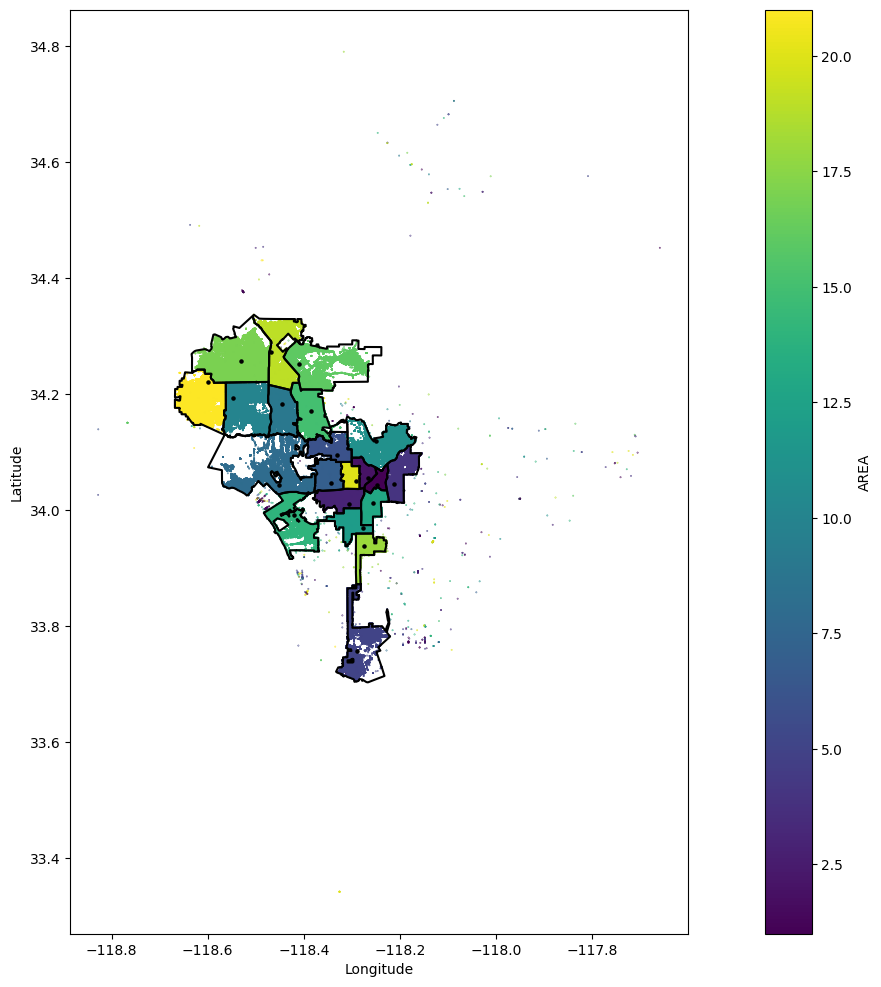

In [ ]:
map_df = gpd.read_file('LAPD_Divisions.shp')

fig, ax = plt.subplots(1, figsize = (20, 12))
map_df.boundary.plot(color='black', ax=ax)
df.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='AREA',  s=0.1, cmap='viridis')
LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=5, c='black')

In [ ]:
# code snippet that could be useful later for determining better bounds
# map_df['geometry'].astype(str)\
#     .str[8:]\
#     .str.replace('(', '')\
#     .str.replace(')', '')\
#     .str.replace(',', '')\
#     .str.split(' ')

In [ ]:
before_size = df.shape[0]

# arbitrarily chosen bounds for LA area
df = df.drop(df.loc[(df['LAT'] <= 33.7) & (df['LAT'] >= 34.37) & (df['LON'] <= -118.7) & (df['LON'] >= -118.15)].index)

after_size = df.shape[0]
print('Before: ', before_size)
print('After: ', after_size)
print('Dropped',before_size - after_size,'rows, which is',(before_size - after_size) / before_size,'% of the entire dataset')

Before:  2787052
After:  2787052
Dropped 0 rows, which is 0.0 % of the entire dataset


So now our dataset just contains the areas within the precinct and not a large area around them. This will help with our clustering and our analysis by removing outlier datapoints. These points outside the precinct boundaries seem randomly assigned to precincts or at least use a pattern that was not noted.  

With this all finished we can plot the whole area again. Additionally we can add each of the latitudes and longitudes from the entire crime set. 

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

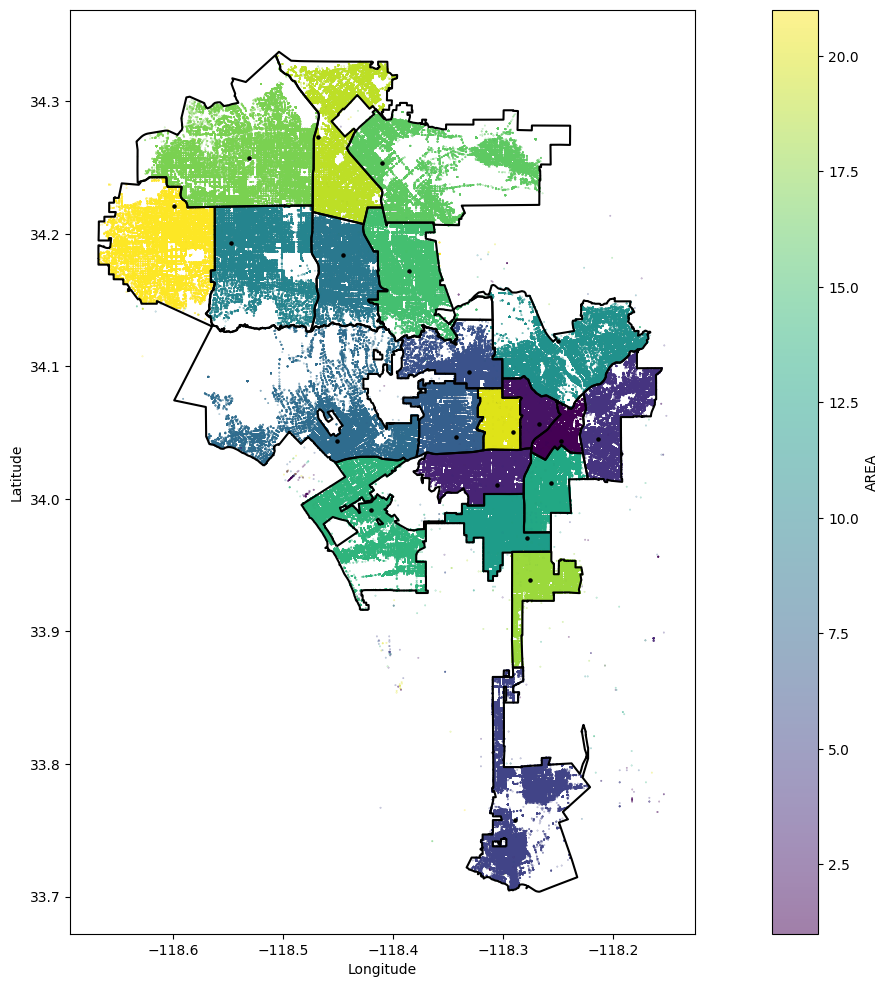

In [ ]:
map_df = gpd.read_file('LAPD_Divisions.shp')
df_plot = df.loc[(df['LAT'] >= 33.7) & (df['LAT'] <= 34.37) & (df['LON'] >= -118.7) & (df['LON'] <= -118.15)]

fig, ax = plt.subplots(1, figsize = (20, 12))
map_df.boundary.plot(color='black', ax=ax)
df_plot.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='AREA',  s=0.1, alpha=0.5, cmap='viridis')
LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=5, c='black')

So the crime distribution is largely containted within the precincts. The black dots are the police station locations themselves. A good thing to take note of is that the police stations are not centered in their respective zones. While some are roughly in the middle, there are also some on the edge of their zones. This is interesting since for effective coverage we would expect them to be centered so they can optimally cover their area. This will likely affect our analysis since our calculated locations will be centered on the crime around them and thus would likely be centered in their zones.

## Crime Counts in Relation to Precinct

Since our research question involves location information we want to focus our explorations around that. Specifically we would like to see if there are similar amounts of crimes commited in each precinct, if each precinct has similar areas, if each precinct has similar coverage.  

First let's look at the number of crimes in each precinct.

One thing that we would be interested in knowing is if there is an equal distribution of crimes between police stations. From this we can see that there is a difference between how many cases each station has handled. This could either mean that some police stations are responsible for a larger area or there are more crimes happening in the areas those stations are covering. 

<AxesSubplot: ylabel='APREC'>

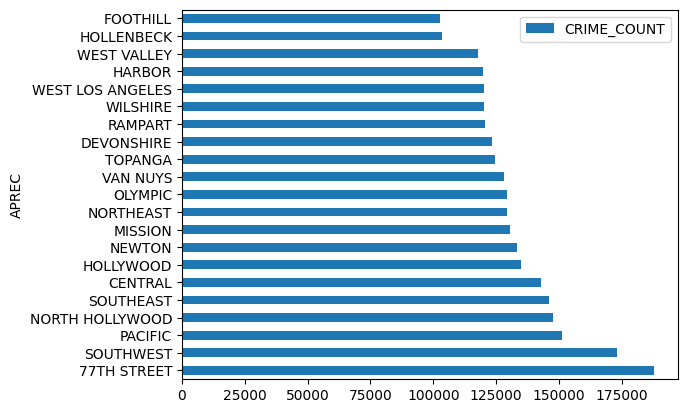

In [ ]:
# setting up a merged crime count table that has counts and area of precincts using df and map_df
crime_counts = map_df.merge(df.groupby('AREA')[['DR_NO']].count().rename(columns={'DR_NO':'CRIME_COUNT'}), left_on='PREC', right_on='AREA')
crime_counts = crime_counts.sort_values(by='CRIME_COUNT', ascending=False)
crime_counts.plot(kind='barh', x='APREC', y='CRIME_COUNT')

While there are a few with less and a few with more it seems that there are similar amounts of crime commited in each precint.

But based on our map we know that the precint's are not all the same size, so can the differences in numbers of crime commited be related to size?

array([[<AxesSubplot: title={'center': 'Number of Crimes Committed'}, ylabel='APREC'>,
        <AxesSubplot: title={'center': 'Area of Precinct'}, ylabel='APREC'>,
        <AxesSubplot: title={'center': 'Number of Crimes Committed/ Area'}, ylabel='APREC'>]],
      dtype=object)

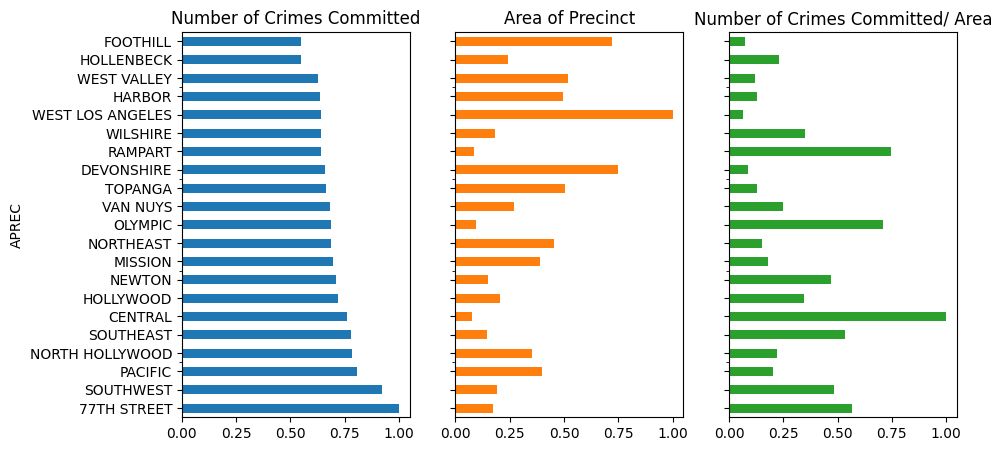

In [ ]:
crime_counts['CRIME_COUNT_VS_AREA'] = crime_counts['CRIME_COUNT'] / crime_counts['AREA']

crime_counts['scaled_AREA'] = crime_counts['AREA'] / crime_counts['AREA'].max()
crime_counts['scaled_CRIME_COUNT'] = crime_counts['CRIME_COUNT'] / crime_counts['CRIME_COUNT'].max()
crime_counts['scaled_CRIME_COUNT_VS_AREA'] = crime_counts['CRIME_COUNT_VS_AREA'] / crime_counts['CRIME_COUNT_VS_AREA'].max()
crime_counts.plot(
    kind='barh', 
    x='APREC', 
    y=['scaled_CRIME_COUNT','scaled_AREA','scaled_CRIME_COUNT_VS_AREA'], 
    subplots=True, layout=(1,3), 
    figsize=(10, 5), 
    sharex=True, sharey=True,
    legend=False,
    title=['Number of Crimes Committed', 'Area of Precinct', 'Number of Crimes Committed/ Area']
)

All of the values have been scaled  
The first bar chart is just the number of crimes commited in each area.  
The second is the area of each precint.  
The last bar chart is the number of crimes / the area of the precinct.  
Since the axis are aligned each corresponds to the same area. So despite having an average number of crimes commited, the Central precinct has a very small area compared to the others and gets a higher value on the right bar chart. Since the bars on the right are not all the same size, then that means there is a disparity between the size of a precint and the number of crimes commited there.

# Time EDA below, not sure if useful for final version

We also wanted to look into the time that crimes happen. The easiest firs thing to look at is the number of crimes committed at each time.

<AxesSubplot: >

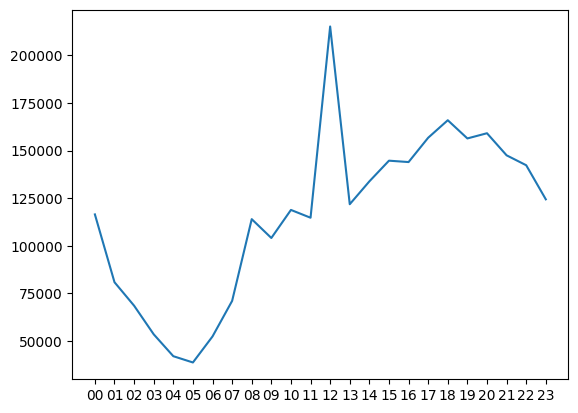

In [ ]:
df["TIME OCC"].str[:2].value_counts().sort_index().plot(xticks=[i for i in range(24)])

This is to see when do most crimes happen. From this we can see that the most common hour for a crime to occur over the past 13 years was at noon. The least common time for a crime to occur was at 5 am. However this is a massive spike at 12 which is odd. A reason for this could be that the dataset only counts crimes reported which means that since it is noon, more people are out and can see/report on a crime. In contrast, people are sleeping at night so there are less people reporting crimes. Another reason for this could be that when a crime happens, they are more focused on the criminal instead of what time it is so when they make a report to an officer, they may choose noon due to it being daylight.

After looking at time, we also wanted to look at it on a date basis.

<Axes: >

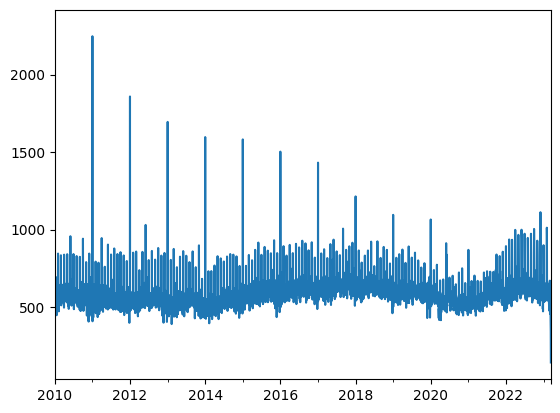

In [ ]:
pd.to_datetime(df["DATE OCC"]).value_counts().sort_index().plot()

In [ ]:
pd.to_datetime(df["DATE OCC"]).value_counts()[:5]

2010-01-01    2287
2011-01-01    2234
2012-01-01    1855
2013-01-01    1694
2014-01-01    1591
Name: DATE OCC, dtype: int64

Weirdly, there are major spikes on New Year's (1/1) each year. We think this might be due to it being some form of default date or they just put a year for the crime and it autofilled to the first of that year. At the moment we do not know if this is the case, but it seems unlikely for there to be such a big spike on the first of the year.

We then changed the scope and did it on a monthly and yearly basis.

<Axes: >

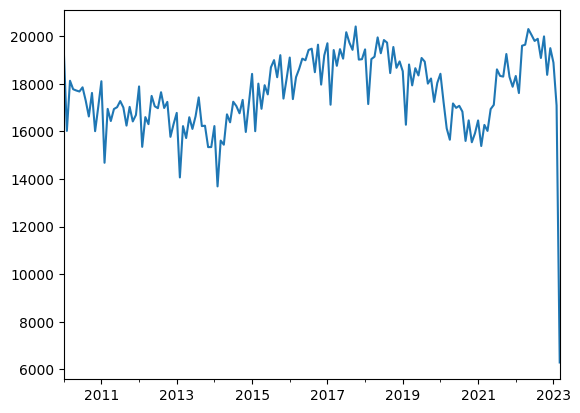

In [ ]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('M').value_counts().sort_index().plot()

Nothing major stood out in this plot, except that there were some random drops on about a yearly basis and some overall trends of more crime during 2017-2019. Addtionally there seems to be a drop in crime from 2019-2021. This could be due to COVID and stay in place mandates. Lastly, 2023 has a giant drop but this is just because it is currently taking in more data.

And graphed on just an aggregated yearly basis (ignored 2023 this time for a better zoom):

<AxesSubplot: >

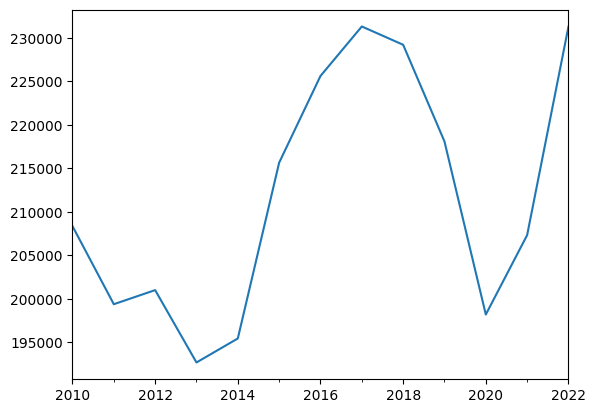

In [ ]:
pd.to_datetime(df["DATE OCC"]).dt.to_period('Y').value_counts().sort_index()[:-1].plot()

Doesn't really show anything different than above. Just similar drop around 2019-2021.

## Looking at New Years data from 2010 to 2023

In [ ]:
# Make a copy of the dataframe and create a new one with a datetime column for easy filtering
datetime_col = pd.to_datetime(df['DATE OCC'])
new_df = df.copy()
new_df['Date'] = datetime_col
new_df.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON,Date
0,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,VIOLATION OF COURT ORDER,48,M,Hispanic/Latin/Mexican,SINGLE FAMILY DWELLING,NaN,Adult Arrest,300 E GAGE AV,NaN,33.9825,-118.2695,2010-02-20
1,11401303,09/12/2010 12:00:00 AM,0045,14,Pacific,1485,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,White,STREET,NaN,Invest Cont,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,2010-09-12
2,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,OTHER MISCELLANEOUS CRIME,0,M,Hispanic/Latin/Mexican,ALLEY,NaN,Invest Cont,1300 E 21ST ST,NaN,34.0224,-118.2524,2010-08-09
3,90631215,01/05/2010 12:00:00 AM,0150,6,Hollywood,646,VIOLATION OF COURT ORDER,47,F,White,STREET,HAND GUN,Invest Cont,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,2010-01-05
4,100100501,01/02/2010 12:00:00 AM,2100,1,Central,176,"RAPE, ATTEMPTED",47,F,Hispanic/Latin/Mexican,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010-01-02


In [ ]:
# Create new dataframe that only contains crimes on New Years Day from 2010 - 2023
new_years = new_df[(new_df['Date'].dt.month == 1) & (new_df['Date'].dt.day == 1)]
new_years.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON,Date
448,100104004,01/01/2010 12:00:00 AM,0130,1,Central,162,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",35,M,Other,POLICE FACILITY,BLUNT INSTRUMENT,Adult Arrest,7TH ST,FLOWER ST,34.0487,-118.2588,2010-01-01
449,100104006,01/01/2010 12:00:00 AM,0230,1,Central,171,BATTERY - SIMPLE ASSAULT,30,M,Hispanic/Latin/Mexican,STREET,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,OLYMPIC BL,FIGUEROA BL,34.0453,-118.2651,2010-01-01
450,100104007,01/01/2010 12:00:00 AM,0100,1,Central,111,BURGLARY FROM VEHICLE,32,M,Hispanic/Latin/Mexican,PARKING UNDERGROUND/BUILDING,NaN,Invest Cont,600 N HILL ST,NaN,34.0591,-118.2412,2010-01-01
451,100104012,01/01/2010 12:00:00 AM,1145,1,Central,152,BATTERY - SIMPLE ASSAULT,51,M,Hispanic/Latin/Mexican,OTHER/OUTSIDE,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,FLOWER,WILSHIRE,34.0494,-118.2581,2010-01-01
452,100104021,01/01/2010 12:00:00 AM,1130,1,Central,100,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",51,M,Black,SIDEWALK,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,6TH ST,WALL ST,34.0428,-118.2461,2010-01-01


In [ ]:
# Over 20,000 crimes committed on the 13 New Years day's alone!
new_years.shape

(20262, 18)

#### 13 days are accounting for over 20,000 crimes in total, with an average of 1558 per day

In [ ]:
20262/13

1558.6153846153845

In [ ]:
365 * 12 + (80)

4460

In [ ]:
(df.shape[0] / 4460) * 13

8167.64932735426

In [ ]:
new_years['Vict Descent'].value_counts()

Hispanic/Latin/Mexican            9225
White                             4166
Black                             3034
Other                             1796
Unknown                            508
Other Asian                        426
Korean                              85
Filipino                            52
Chinese                             20
Japanese                            12
American Indian/Alaskan Native      10
Vietnamese                           6
Hawaiian                             5
Pacific Islander                     4
Asian Indian                         4
Guamanian                            1
Cambodian                            1
Name: Vict Descent, dtype: int64

In [ ]:
top_20 = new_years['Crm Cd Desc'].value_counts()[:20]
top_20

THEFT OF IDENTITY                                           6542
CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)    1376
BATTERY - SIMPLE ASSAULT                                    1044
INTIMATE PARTNER - SIMPLE ASSAULT                            811
BURGLARY FROM VEHICLE                                        643
VEHICLE - STOLEN                                             623
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     599
BURGLARY                                                     595
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT               584
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)      560
THEFT PLAIN - PETTY ($950 & UNDER)                           524
RAPE, FORCIBLE                                               513
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              485
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                     430
SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ     386
LETTERS, LEWD  -  TELEPHO

In [21]:
plt.barh(top_20.index, top_20)
plt.show()

NameError: name 'top_20' is not defined